In [1]:
import numpy as np

In [2]:
import datasets

/home/josiah/miniconda3/envs/kaggle1/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
np.load('../data/pad_false/train_sm_name.npy', allow_pickle=True)
np.load('../data/pad_false/train_ChemBERTa_v2_77MTR_cls_pad_False.npy', allow_pickle=True)


array([[-0.2681742 ,  0.        , -0.38007   , ..., -0.5604895 ,
         0.41710252, -0.08229849],
       [-0.2681742 ,  0.        , -0.38007   , ..., -0.5604895 ,
         0.41710252, -0.08229849],
       [-0.2681742 ,  0.        , -0.38007   , ..., -0.5604895 ,
         0.41710252, -0.08229849],
       ...,
       [ 0.33149236,  0.        , -0.24462274, ..., -0.32275528,
         0.08757384,  0.6201978 ],
       [ 0.33149236,  0.        , -0.24462274, ..., -0.32275528,
         0.08757384,  0.6201978 ],
       [ 0.33149236,  0.        , -0.24462274, ..., -0.32275528,
         0.08757384,  0.6201978 ]], dtype=float32)

In [10]:
!wget https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/pubchem_10m.txt.zip
!unzip pubchem_10m.txt.zip

--2024-04-29 21:38:13--  https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/pubchem_10m.txt.zip
Resolving deepchemdata.s3-us-west-1.amazonaws.com (deepchemdata.s3-us-west-1.amazonaws.com)... 52.219.113.162, 52.219.220.178, 52.219.193.26, ...
Connecting to deepchemdata.s3-us-west-1.amazonaws.com (deepchemdata.s3-us-west-1.amazonaws.com)|52.219.113.162|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 130376753 (124M) [application/zip]
Saving to: ‘pubchem_10m.txt.zip.1’

pubchem_10m.txt.zip 100%[===================>] 124.34M  73.1MB/s    in 1.7s    

2024-04-29 21:38:15 (73.1 MB/s) - ‘pubchem_10m.txt.zip.1’ saved [130376753/130376753]

Archive:  pubchem_10m.txt.zip
  inflating: pubchem-10m.txt         


In [3]:
with open("pubchem-10m.txt", "r") as grilled_cheese:
    lines = grilled_cheese.readlines()
lines = [l.rstrip("\n") for l in lines]

In [30]:
import pandas as pd
df = pd.DataFrame({'SMILES':lines})
df['Count'] = df['SMILES'].str.len()
df=df[df.Count < 126]
df = df[df.Count > 12]
from datasets import Dataset
dataset = Dataset.from_pandas(df)


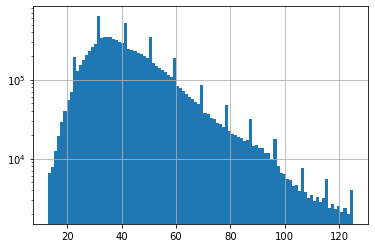

In [31]:
import matplotlib.pyplot as plt
df.Count.hist(bins=100)
plt.yscale('log')

In [35]:
from transformers import BertTokenizer
import collections
import os
import re
import importlib.resources
from typing import List, Optional
from transformers import BertTokenizer
from logging import getLogger

logger = getLogger(__name__)
"""
SMI_REGEX_PATTERN: str
SMILES regex pattern for tokenization. Designed by Schwaller et. al.

References
----------
.. [1]  Philippe Schwaller, Teodoro Laino, Théophile Gaudin, Peter Bolgar, Christopher A. Hunter, Costas Bekas, and Alpha A. Lee
ACS Central Science 2019 5 (9): Molecular Transformer: A Model for Uncertainty-Calibrated Chemical Reaction Prediction
1572-1583 DOI: 10.1021/acscentsci.9b00576
"""

SMI_REGEX_PATTERN = r"""(\[[^\]]+]|Br?|Cl?|N|O|S|P|F|I|b|c|n|o|s|p|\(|\)|\.|=|#|-|\+|\\|\/|:|~|@|\?|>>?|\*|\$|\%[0-9]{2}|[0-9])"""

# add vocab_file dict
VOCAB_FILES_NAMES = {"vocab_file": "vocab.txt"}
def load_vocab(vocab_file):
    """Loads a vocabulary file into a dictionary."""
    vocab = collections.OrderedDict()
    with open(vocab_file, "r", encoding="utf-8") as reader:
        tokens = reader.readlines()
    for index, token in enumerate(tokens):
        token = token.rstrip("\n")
        vocab[token] = index
    return vocab
class BasicSmilesTokenizer(object):
    """
    Run basic SMILES tokenization using a regex pattern developed by Schwaller et. al.
    This tokenizer is to be used when a tokenizer that does not require the transformers library by HuggingFace is required.

    Examples
    --------
    >>> from deepchem.feat.smiles_tokenizer import BasicSmilesTokenizer
    >>> tokenizer = BasicSmilesTokenizer()
    >>> print(tokenizer.tokenize("CC(=O)OC1=CC=CC=C1C(=O)O"))
    ['C', 'C', '(', '=', 'O', ')', 'O', 'C', '1', '=', 'C', 'C', '=', 'C', 'C', '=', 'C', '1', 'C', '(', '=', 'O', ')', 'O']


    References
    ----------
    .. [1] Philippe Schwaller, Teodoro Laino, Théophile Gaudin, Peter Bolgar, Christopher A. Hunter, Costas Bekas, and Alpha A. Lee
        ACS Central Science 2019 5 (9): Molecular Transformer: A Model for Uncertainty-Calibrated Chemical Reaction Prediction
        1572-1583 DOI: 10.1021/acscentsci.9b00576
    """

    def __init__(self, regex_pattern: str = SMI_REGEX_PATTERN):
        """Constructs a BasicSMILESTokenizer.

        Parameters
        ----------
        regex: string
            SMILES token regex
        """
        self.regex_pattern = regex_pattern
        self.regex = re.compile(self.regex_pattern)

    def tokenize(self, text):
        """Basic Tokenization of a SMILES.
        """
        tokens = [token for token in self.regex.findall(text)]
        return tokens

class SmilesTokenizer(BertTokenizer):
    """
    Creates the SmilesTokenizer class. The tokenizer heavily inherits from the BertTokenizer
    implementation found in Huggingface's transformers library. It runs a WordPiece tokenization
    algorithm over SMILES strings using the tokenisation SMILES regex developed by Schwaller et. al.

    Please see https://github.com/huggingface/transformers
    and https://github.com/rxn4chemistry/rxnfp for more details.

    Examples
    --------
    >>> from deepchem.feat.smiles_tokenizer import SmilesTokenizer
    >>> current_dir = os.path.dirname(os.path.realpath(__file__))
    >>> vocab_path = os.path.join(current_dir, 'tests/data', 'vocab.txt')
    >>> tokenizer = SmilesTokenizer(vocab_path)
    >>> print(tokenizer.encode("CC(=O)OC1=CC=CC=C1C(=O)O"))
    [12, 16, 16, 17, 22, 19, 18, 19, 16, 20, 22, 16, 16, 22, 16, 16, 22, 16, 20, 16, 17, 22, 19, 18, 19, 13]


    References
    ----------
    .. [1] Schwaller, Philippe; Probst, Daniel; Vaucher, Alain C.; Nair, Vishnu H; Kreutter, David;
        Laino, Teodoro; et al. (2019): Mapping the Space of Chemical Reactions using Attention-Based Neural
        Networks. ChemRxiv. Preprint. https://doi.org/10.26434/chemrxiv.9897365.v3

    Note
    ----
    This class requires huggingface's transformers and tokenizers libraries to be installed.
    """
    #vocab_files_names = VOCAB_FILES_NAMES

    def __init__(
        self,
        vocab_file: str = '',
        # unk_token="[UNK]",
        # sep_token="[SEP]",
        # pad_token="[PAD]",
        # cls_token="[CLS]",
        # mask_token="[MASK]",
        **kwargs):
        """Constructs a SmilesTokenizer.

        Parameters
        ----------
        vocab_file: str
            Path to a SMILES character per line vocabulary file.
            Default vocab file is found in deepchem/feat/tests/data/vocab.txt
        """

        super().__init__(vocab_file, **kwargs)

        if not os.path.isfile(vocab_file):
            raise ValueError(
                "Can't find a vocab file at path '{}'.".format(vocab_file))
        self.vocab = load_vocab(vocab_file)
        self.highest_unused_index = max([
            i for i, v in enumerate(self.vocab.keys())
            if v.startswith("[unused")
        ])
        self.ids_to_tokens = collections.OrderedDict([
            (ids, tok) for tok, ids in self.vocab.items()
        ])
        self.basic_tokenizer = BasicSmilesTokenizer()

    @property
    def vocab_size(self):
        return len(self.vocab)

    @property
    def vocab_list(self):
        return list(self.vocab.keys())

    def _tokenize(self, text: str, max_seq_length: int = 512, **kwargs):
        """Tokenize a string into a list of tokens.

        Parameters
        ----------
        text: str
            Input string sequence to be tokenized.
        """

        max_len_single_sentence = max_seq_length - 2
        split_tokens = [
            token for token in self.basic_tokenizer.tokenize(text)
            [:max_len_single_sentence]
        ]
        return split_tokens

    def _convert_token_to_id(self, token: str):
        """Converts a token (str/unicode) in an id using the vocab.

        Parameters
        ----------
        token: str
            String token from a larger sequence to be converted to a numerical id.
        """

        return self.vocab.get(token, self.vocab.get(self.unk_token))

    def _convert_id_to_token(self, index: int):
        """Converts an index (integer) in a token (string/unicode) using the vocab.

        Parameters
        ----------
        index: int
            Integer index to be converted back to a string-based token as part of a larger sequence.
        """

        return self.ids_to_tokens.get(index, self.unk_token)

    def convert_tokens_to_string(self, tokens: List[str]):
        """Converts a sequence of tokens (string) in a single string.

        Parameters
        ----------
        tokens: List[str]
            List of tokens for a given string sequence.

        Returns
        -------
        out_string: str
            Single string from combined tokens.
        """

        out_string: str = " ".join(tokens).replace(" ##", "").strip()
        return out_string

    def add_special_tokens_ids_single_sequence(self,
                                               token_ids: List[Optional[int]]):
        """Adds special tokens to the a sequence for sequence classification tasks.

        A BERT sequence has the following format: [CLS] X [SEP]

        Parameters
        ----------
        token_ids: list[int]
            list of tokenized input ids. Can be obtained using the encode or encode_plus methods.
        """

        return [self.cls_token_id] + token_ids + [self.sep_token_id]

    def add_special_tokens_single_sequence(self, tokens: List[str]):
        """Adds special tokens to the a sequence for sequence classification tasks.
        A BERT sequence has the following format: [CLS] X [SEP]

        Parameters
        ----------
        tokens: List[str]
            List of tokens for a given string sequence.
        """
        return [self.cls_token] + tokens + [self.sep_token]

    def add_special_tokens_ids_sequence_pair(
            self, token_ids_0: List[Optional[int]],
            token_ids_1: List[Optional[int]]) -> List[Optional[int]]:
        """Adds special tokens to a sequence pair for sequence classification tasks.
        A BERT sequence pair has the following format: [CLS] A [SEP] B [SEP]

        Parameters
        ----------
        token_ids_0: List[int]
            List of ids for the first string sequence in the sequence pair (A).
        token_ids_1: List[int]
            List of tokens for the second string sequence in the sequence pair (B).
        """

        sep = [self.sep_token_id]
        cls = [self.cls_token_id]

        return cls + token_ids_0 + sep + token_ids_1 + sep

    def add_padding_tokens(self,
                           token_ids: List[Optional[int]],
                           length: int,
                           right: bool = True) -> List[Optional[int]]:
        """Adds padding tokens to return a sequence of length max_length.
        By default padding tokens are added to the right of the sequence.

        Parameters
        ----------
        token_ids: list[optional[int]]
            list of tokenized input ids. Can be obtained using the encode or encode_plus methods.
        length: int
            TODO
        right: bool, default True
            TODO

        Returns
        -------
        List[int]
            TODO
        """
        padding = [self.pad_token_id] * (length - len(token_ids))

        if right:
            return token_ids + padding
        else:
            return padding + token_ids

    def save_vocabulary(
        self,
        save_directory: str,
        filename_prefix: Optional[str] = None
    ):  # -> Tuple[str]: doctest issue raised with this return type annotation
        """Save the tokenizer vocabulary to a file.

        Parameters
        ----------
        vocab_path: obj: str
            The directory in which to save the SMILES character per line vocabulary file.
            Default vocab file is found in deepchem/feat/tests/data/vocab.txt

        Returns
        -------
        vocab_file: Tuple
            Paths to the files saved.
            typle with string to a SMILES character per line vocabulary file.
            Default vocab file is found in deepchem/feat/tests/data/vocab.txt
        """
        index = 0
        if os.path.isdir(save_directory):
            vocab_file = os.path.join(save_directory,
                                      VOCAB_FILES_NAMES["vocab_file"])
        else:
            vocab_file = save_directory
        with open(vocab_file, "w", encoding="utf-8") as writer:
            for token, token_index in sorted(self.vocab.items(),
                                             key=lambda kv: kv[1]):
                if index != token_index:
                    logger.warning(
                        "Saving vocabulary to {}: vocabulary indices are not consecutive."
                        " Please check that the vocabulary is not corrupted!".
                        format(vocab_file))
                    index = token_index
                writer.write(token + "\n")
                index += 1
        return (vocab_file,)

In [36]:
tokenizer=SmilesTokenizer('../data/vocab.txt')
tokenizer('CCH([Mg100])', max_length=256, padding='max_length')

{'input_ids': [12, 16, 16, 17, 11, 18, 13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [11]:
dataset.rename_column('0','SMILES')

Dataset({
    features: ['SMILES'],
    num_rows: 10000000
})

In [51]:
tokenizer.vocab

OrderedDict([('[PAD]', 0),
             ('[unused1]', 1),
             ('[unused2]', 2),
             ('[unused3]', 3),
             ('[unused4]', 4),
             ('[unused5]', 5),
             ('[unused6]', 6),
             ('[unused7]', 7),
             ('[unused8]', 8),
             ('[unused9]', 9),
             ('[unused10]', 10),
             ('[UNK]', 11),
             ('[CLS]', 12),
             ('[SEP]', 13),
             ('[MASK]', 14),
             ('c', 15),
             ('C', 16),
             ('(', 17),
             (')', 18),
             ('O', 19),
             ('1', 20),
             ('2', 21),
             ('=', 22),
             ('N', 23),
             ('.', 24),
             ('n', 25),
             ('3', 26),
             ('F', 27),
             ('Cl', 28),
             ('>>', 29),
             ('~', 30),
             ('-', 31),
             ('4', 32),
             ('[C@H]', 33),
             ('S', 34),
             ('[C@@H]', 35),
             ('[O-]', 36),
      

In [44]:
def encode_smiles(sample):
    #selfie = sf.encoder(sample['canonical_smiles'])
    out_sample=tokenizer(sample['SMILES'], 
                                         max_length=128,
                                          padding='max_length',
                                          truncation=True) #,return_tensors = 'pt')
    sample['input_ids']=out_sample['input_ids']
    sample['attention_mask']=out_sample['attention_mask']
    return sample
dataset = dataset.map(encode_smiles)
#dataset_dict['test'] = dataset_dict['test'].map(encode_smiles, num_proc=8)

Map:   0%|          | 0/9926543 [00:00<?, ? examples/s]

In [45]:
dataset.save_to_disk('encoded_pubchem10M')

Saving the dataset (0/15 shards):   0%|          | 0/9926543 [00:00<?, ? examples/s]

In [46]:
dataset

Dataset({
    features: ['SMILES', 'Count', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 9926543
})

In [50]:
len(tokenizer.vocab)

591

In [118]:
from rdkit import Chem
from collections import deque

def rotate_smiles(smiles,num): #,canonical=True,isomericSmiles=True):
    """Perform a rotation of a SMILES string
    must be RDKit sanitizable"""
    m = Chem.MolFromSmiles(smiles)
    ans = deque(list(range(m.GetNumAtoms())))
    ans.rotate(num)
    nm = Chem.RenumberAtoms(m,ans)
    return Chem.MolToSmiles(nm, canonical=False)#, canonical=canonical, isomericSmiles=isomericSmiles)


In [125]:
print(tokenizer(dataset[1]['SMILES']))
print(tokenizer(rotate_smiles(dataset[1]['SMILES'],10000))['input_ids'])
print(tokenizer(rotate_smiles(dataset[1]['SMILES'],2))['input_ids'])


{'input_ids': [12, 16, 16, 121, 17, 16, 16, 18, 16, 20, 16, 16, 16, 17, 116, 16, 21, 16, 16, 21, 18, 17, 16, 17, 22, 19, 18, 36, 18, 16, 20, 13], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
[12, 16, 17, 22, 19, 18, 17, 36, 18, 16, 20, 17, 116, 16, 21, 16, 16, 21, 18, 16, 16, 17, 121, 17, 16, 16, 18, 16, 16, 18, 16, 16, 20, 13]
[12, 36, 16, 17, 16, 20, 17, 116, 16, 21, 16, 16, 21, 18, 16, 16, 17, 121, 17, 16, 16, 18, 16, 16, 18, 16, 16, 20, 18, 22, 19, 13]


In [130]:
dict(tokenizer(dataset[1]['SMILES']))

{'input_ids': [12,
  16,
  16,
  121,
  17,
  16,
  16,
  18,
  16,
  20,
  16,
  16,
  16,
  17,
  116,
  16,
  21,
  16,
  16,
  21,
  18,
  17,
  16,
  17,
  22,
  19,
  18,
  36,
  18,
  16,
  20,
  13],
 'token_type_ids': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1]}

In [38]:
import datasets
dataset = datasets.load_from_disk('/shared/tox21_hepg2_combined_split').with_format('torch')
print(dataset['test'][0:5]['chem_input_ids'][:,:10])
print(dataset['test'][0:5]['canonical_smiles'])

tensor([[   0,   50,   33,   39,   21,  270,  263,   50,   13,   71],
        [   0,  283,   21,  300,   12, 1064,  263,   55,  274,  271],
        [   0,   51,   33,   39,   12,  278,   21,  268,   21,   17],
        [   0,  291,   21,   39,  263,   55,   13,  291,   33,   39],
        [   0,  298,   19,   39,   33,   39,   12,   19,   39,  263]])
['N=C1NC(=N)c2cc3ccccc3cc21', 'COc1nn(CSP(=S)(OC)OC)c(=O)s1', 'O=C(Nc1ccccc1-c1ccc(Cl)cc1)c1cccnc1Cl', 'CN1C(=S)CN=C(c2ccccc2)c2cc(Cl)ccc21', 'CO/C=C(/C(=O)OC)c1ccccc1Oc1cc(Oc2ccccc2C#N)ncn1']


In [14]:
import torch.nn as nn
import torch

In [15]:
sig = nn.Sigmoid()

In [20]:
sig(torch.Tensor([2.320523262023926]))

tensor([0.9106])

# Fine tuning DS

In [5]:
import deepchem as dc
import os
os.environ['DEEPCHEM_DATA_DIR']='/efs-private/deepchem_data'
print(dc.utils.get_data_dir())

/efs-private/deepchem_data


In [76]:
mn_datasets = {
    'QM7': dc.molnet.load_qm7,
    #'QM7b': dc.molnet.load_qm7b,
    #'QM8': dc.molnet.load_qm8,
    'QM9': dc.molnet.load_qm9,
    'ESOL': dc.molnet.load_delaney,
    'FreeSolv': dc.molnet.load_freesolv,
    'Lipophilicity': dc.molnet.load_lipo,
    #'PCBA': dc.molnet.load_pcba,
    #'MUV': dc.molnet.load_muv,
    'HIV': dc.molnet.load_hiv,
    #'PDBbind': dc.molnet.load_pdbbind,
    'BACE': dc.molnet.load_bace_classification,
    'BBBP': dc.molnet.load_bbbp,
    #'Tox21': dc.molnet.load_tox21,
    #'ToxCast': dc.molnet.load_toxcast,
    #'SIDER': dc.molnet.load_sider,
    #'ClinTox': dc.molnet.load_clintox,
}

In [77]:
mn_datasets_load = {k:v() for k,v in mn_datasets.items()}

In [69]:
import sys
sys.path.append('/efs-private/chemjepa/chemjepa')
from utils.smiles import absolute_smiles

In [96]:
dsn = 'QM7'
iterator = mn_datasets_load[dsn][1][0].itersamples()
tasks = mn_datasets_load[dsn][0]
print(tasks)
def get_samples(ds, idx=0):
    iterator = ds[1][idx].itersamples()
    while True:
        try:
            X, y, w, ids = next(iterator)
            yield {'canonical_smiles':absolute_smiles(ids), 'targets':y}
        except StopIteration as e:
            return

['u0_atom']


In [102]:
from datasets import Dataset, DatasetDict
import os
for k,v in mn_datasets_load.items():
    print(k)
    tasks = mn_datasets_load[k][0]
    with open(os.path.join('/shared',f"{k}_features.txt"), 'w') as f:
        f.writelines(tasks)
    dsd = DatasetDict()
    data = [x for x in iter(get_samples(mn_datasets_load[k], idx=0))]
    dsd['train'] = Dataset.from_list(data)
    data = [x for x in iter(get_samples(mn_datasets_load[k], idx=1))]
    dsd['test'] = Dataset.from_list(data)
    data = [x for x in iter(get_samples(mn_datasets_load[k], idx=2))]
    dsd['val'] = Dataset.from_list(data)
    dsd.save_to_disk(os.path.join('/shared',f"{k}_dataset"))

QM7


Saving the dataset (0/1 shards):   0%|          | 0/5470 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/684 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/684 [00:00<?, ? examples/s]

QM9


Saving the dataset (0/1 shards):   0%|          | 0/105984 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/13248 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/13248 [00:00<?, ? examples/s]

ESOL


Saving the dataset (0/1 shards):   0%|          | 0/902 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/113 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/113 [00:00<?, ? examples/s]

FreeSolv


Saving the dataset (0/1 shards):   0%|          | 0/513 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/64 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/65 [00:00<?, ? examples/s]

Lipophilicity


Saving the dataset (0/1 shards):   0%|          | 0/3360 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/420 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/420 [00:00<?, ? examples/s]

HIV


Saving the dataset (0/1 shards):   0%|          | 0/32901 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/4113 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/4113 [00:00<?, ? examples/s]

BACE


Saving the dataset (0/1 shards):   0%|          | 0/1210 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/151 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/152 [00:00<?, ? examples/s]

BBBP


Saving the dataset (0/1 shards):   0%|          | 0/1631 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/204 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/204 [00:00<?, ? examples/s]

In [103]:
dsd

DatasetDict({
    train: Dataset({
        features: ['canonical_smiles', 'targets'],
        num_rows: 1631
    })
    test: Dataset({
        features: ['canonical_smiles', 'targets'],
        num_rows: 204
    })
    val: Dataset({
        features: ['canonical_smiles', 'targets'],
        num_rows: 204
    })
})

In [2]:
!conda run -n kaggle1 pip install deepchem

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 778.3 kB/s eta 0:00:00
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.1/41.1 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.1/33.1 MB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 15.0 MB/s eta 0:00:00
Using cached mpmath-1.3.0-py3-none-any.whl (536 kB)



In [3]:
import deepchem as dc
from deepchem.feat.molecule_featurizers import MolGraphConvFeaturizer

featurizer = MolGraphConvFeaturizer(use_edges=True)
dataset_dc = dc.molnet.load_qm9(featurizer=featurizer)
tasks, dataset, transformers = dataset_dc
train, valid, test = dataset

x,y,w,ids = train.X, train.y, train.w, train.ids

Skipped loading some Pytorch utilities, missing a dependency. No module named 'torch'


This module requires PyTorch to be installed.


No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
/home/josiah/miniconda3/envs/kaggle1/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
Skipped loading some PyTorch models, missing a dependency. No module named 'torch'
No module named 'torch'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch'
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'torch'
Skipped loading some Jax models, missing a dependency. No module named 'j

[01:41:45] Explicit valence for atom # 2 C, 5, is greater than permitted
[01:41:45] ERROR: Could not sanitize molecule ending on line 234189
[01:41:45] ERROR: Explicit valence for atom # 2 C, 5, is greater than permitted
[01:41:45] Explicit valence for atom # 1 C, 5, is greater than permitted
[01:41:45] ERROR: Could not sanitize molecule ending on line 235350
[01:41:45] ERROR: Explicit valence for atom # 1 C, 5, is greater than permitted
[01:41:45] Explicit valence for atom # 1 C, 5, is greater than permitted
[01:41:45] ERROR: Could not sanitize molecule ending on line 235388
[01:41:45] ERROR: Explicit valence for atom # 1 C, 5, is greater than permitted
[01:41:45] Explicit valence for atom # 1 C, 5, is greater than permitted
[01:41:45] ERROR: Could not sanitize molecule ending on line 235547
[01:41:45] ERROR: Explicit valence for atom # 1 C, 5, is greater than permitted
[01:41:45] Explicit valence for atom # 1 C, 5, is greater than permitted
[01:41:45] ERROR: Could not sanitize molecu

[01:41:54] Explicit valence for atom # 2 C, 5, is greater than permitted
[01:41:54] ERROR: Could not sanitize molecule ending on line 408871
[01:41:54] ERROR: Explicit valence for atom # 2 C, 5, is greater than permitted
[01:41:54] Explicit valence for atom # 2 C, 5, is greater than permitted
[01:41:54] ERROR: Could not sanitize molecule ending on line 408915
[01:41:54] ERROR: Explicit valence for atom # 2 C, 5, is greater than permitted
[01:41:54] Explicit valence for atom # 2 C, 5, is greater than permitted
[01:41:54] ERROR: Could not sanitize molecule ending on line 439217
[01:41:54] ERROR: Explicit valence for atom # 2 C, 5, is greater than permitted
[01:41:54] Explicit valence for atom # 2 C, 5, is greater than permitted
[01:41:54] ERROR: Could not sanitize molecule ending on line 439255
[01:41:54] ERROR: Explicit valence for atom # 2 C, 5, is greater than permitted
[01:41:54] Explicit valence for atom # 2 C, 5, is greater than permitted
[01:41:54] ERROR: Could not sanitize molecu

[01:42:15] Explicit valence for atom # 2 C, 5, is greater than permitted
[01:42:15] ERROR: Could not sanitize molecule ending on line 659096
[01:42:15] ERROR: Explicit valence for atom # 2 C, 5, is greater than permitted
[01:42:15] Explicit valence for atom # 2 C, 5, is greater than permitted
[01:42:15] ERROR: Could not sanitize molecule ending on line 659134
[01:42:15] ERROR: Explicit valence for atom # 2 C, 5, is greater than permitted
[01:42:15] Explicit valence for atom # 2 C, 5, is greater than permitted
[01:42:15] ERROR: Could not sanitize molecule ending on line 659400
[01:42:15] ERROR: Explicit valence for atom # 2 C, 5, is greater than permitted
[01:42:15] Explicit valence for atom # 2 C, 5, is greater than permitted
[01:42:15] ERROR: Could not sanitize molecule ending on line 659599
[01:42:15] ERROR: Explicit valence for atom # 2 C, 5, is greater than permitted
[01:42:15] Explicit valence for atom # 2 C, 5, is greater than permitted
[01:42:15] ERROR: Could not sanitize molecu

[01:42:16] Explicit valence for atom # 4 C, 5, is greater than permitted
[01:42:16] ERROR: Could not sanitize molecule ending on line 739075
[01:42:16] ERROR: Explicit valence for atom # 4 C, 5, is greater than permitted
[01:42:16] Explicit valence for atom # 4 C, 5, is greater than permitted
[01:42:16] ERROR: Could not sanitize molecule ending on line 739222
[01:42:16] ERROR: Explicit valence for atom # 4 C, 5, is greater than permitted
[01:42:16] Explicit valence for atom # 4 C, 5, is greater than permitted
[01:42:16] ERROR: Could not sanitize molecule ending on line 739377
[01:42:16] ERROR: Explicit valence for atom # 4 C, 5, is greater than permitted
[01:42:16] Explicit valence for atom # 4 C, 5, is greater than permitted
[01:42:16] ERROR: Could not sanitize molecule ending on line 739486
[01:42:16] ERROR: Explicit valence for atom # 4 C, 5, is greater than permitted
[01:42:16] Explicit valence for atom # 4 C, 5, is greater than permitted
[01:42:16] ERROR: Could not sanitize molecu

[01:42:56] Explicit valence for atom # 2 C, 5, is greater than permitted
[01:42:56] ERROR: Could not sanitize molecule ending on line 1325851
[01:42:56] ERROR: Explicit valence for atom # 2 C, 5, is greater than permitted
[01:42:56] Explicit valence for atom # 2 C, 5, is greater than permitted
[01:42:56] ERROR: Could not sanitize molecule ending on line 1326112
[01:42:56] ERROR: Explicit valence for atom # 2 C, 5, is greater than permitted
[01:42:56] Explicit valence for atom # 2 C, 5, is greater than permitted
[01:42:56] ERROR: Could not sanitize molecule ending on line 1326481
[01:42:56] ERROR: Explicit valence for atom # 2 C, 5, is greater than permitted
[01:42:56] Explicit valence for atom # 2 C, 5, is greater than permitted
[01:42:56] ERROR: Could not sanitize molecule ending on line 1326520
[01:42:56] ERROR: Explicit valence for atom # 2 C, 5, is greater than permitted
[01:42:56] Explicit valence for atom # 2 C, 5, is greater than permitted
[01:42:56] ERROR: Could not sanitize mo

[01:42:56] Explicit valence for atom # 3 C, 5, is greater than permitted
[01:42:56] ERROR: Could not sanitize molecule ending on line 1452755
[01:42:56] ERROR: Explicit valence for atom # 3 C, 5, is greater than permitted
[01:42:56] Explicit valence for atom # 3 C, 5, is greater than permitted
[01:42:56] ERROR: Could not sanitize molecule ending on line 1452799
[01:42:56] ERROR: Explicit valence for atom # 3 C, 5, is greater than permitted
[01:42:56] Explicit valence for atom # 5 C, 5, is greater than permitted
[01:42:56] ERROR: Could not sanitize molecule ending on line 1453160
[01:42:56] ERROR: Explicit valence for atom # 5 C, 5, is greater than permitted
[01:42:56] Explicit valence for atom # 3 C, 5, is greater than permitted
[01:42:56] ERROR: Could not sanitize molecule ending on line 1453336
[01:42:56] ERROR: Explicit valence for atom # 3 C, 5, is greater than permitted
[01:42:56] Explicit valence for atom # 3 C, 5, is greater than permitted
[01:42:56] ERROR: Could not sanitize mo

[01:43:06] Explicit valence for atom # 5 C, 5, is greater than permitted
[01:43:06] ERROR: Could not sanitize molecule ending on line 1504494
[01:43:06] ERROR: Explicit valence for atom # 5 C, 5, is greater than permitted
[01:43:06] Explicit valence for atom # 5 C, 5, is greater than permitted
[01:43:06] ERROR: Could not sanitize molecule ending on line 1504631
[01:43:06] ERROR: Explicit valence for atom # 5 C, 5, is greater than permitted
[01:43:06] Explicit valence for atom # 5 C, 5, is greater than permitted
[01:43:06] ERROR: Could not sanitize molecule ending on line 1506064
[01:43:06] ERROR: Explicit valence for atom # 5 C, 5, is greater than permitted
[01:43:06] Explicit valence for atom # 1 C, 5, is greater than permitted
[01:43:06] ERROR: Could not sanitize molecule ending on line 1506109
[01:43:06] ERROR: Explicit valence for atom # 1 C, 5, is greater than permitted
[01:43:06] Explicit valence for atom # 1 C, 5, is greater than permitted
[01:43:06] ERROR: Could not sanitize mo

[01:43:07] Explicit valence for atom # 6 C, 5, is greater than permitted
[01:43:07] ERROR: Could not sanitize molecule ending on line 1605871
[01:43:07] ERROR: Explicit valence for atom # 6 C, 5, is greater than permitted
[01:43:07] Explicit valence for atom # 6 C, 5, is greater than permitted
[01:43:07] ERROR: Could not sanitize molecule ending on line 1606014
[01:43:07] ERROR: Explicit valence for atom # 6 C, 5, is greater than permitted
[01:43:07] Explicit valence for atom # 3 C, 5, is greater than permitted
[01:43:07] ERROR: Could not sanitize molecule ending on line 1606062
[01:43:07] ERROR: Explicit valence for atom # 3 C, 5, is greater than permitted
[01:43:07] Explicit valence for atom # 6 C, 5, is greater than permitted
[01:43:07] ERROR: Could not sanitize molecule ending on line 1606247
[01:43:07] ERROR: Explicit valence for atom # 6 C, 5, is greater than permitted
[01:43:07] Explicit valence for atom # 6 C, 5, is greater than permitted
[01:43:07] ERROR: Could not sanitize mo

[01:43:18] Explicit valence for atom # 3 C, 5, is greater than permitted
[01:43:18] ERROR: Could not sanitize molecule ending on line 1703987
[01:43:18] ERROR: Explicit valence for atom # 3 C, 5, is greater than permitted
[01:43:18] Explicit valence for atom # 3 C, 5, is greater than permitted
[01:43:18] ERROR: Could not sanitize molecule ending on line 1704020
[01:43:18] ERROR: Explicit valence for atom # 3 C, 5, is greater than permitted
[01:43:18] Explicit valence for atom # 3 C, 5, is greater than permitted
[01:43:18] ERROR: Could not sanitize molecule ending on line 1704202
[01:43:18] ERROR: Explicit valence for atom # 3 C, 5, is greater than permitted
[01:43:18] Explicit valence for atom # 4 C, 5, is greater than permitted
[01:43:18] ERROR: Could not sanitize molecule ending on line 1728123
[01:43:18] ERROR: Explicit valence for atom # 4 C, 5, is greater than permitted
[01:43:18] Explicit valence for atom # 5 C, 5, is greater than permitted
[01:43:18] ERROR: Could not sanitize mo

[01:43:28] Explicit valence for atom # 4 C, 5, is greater than permitted
[01:43:28] ERROR: Could not sanitize molecule ending on line 1917509
[01:43:28] ERROR: Explicit valence for atom # 4 C, 5, is greater than permitted
[01:43:28] Explicit valence for atom # 5 C, 5, is greater than permitted
[01:43:28] ERROR: Could not sanitize molecule ending on line 1918006
[01:43:28] ERROR: Explicit valence for atom # 5 C, 5, is greater than permitted
[01:43:28] Explicit valence for atom # 4 C, 5, is greater than permitted
[01:43:28] ERROR: Could not sanitize molecule ending on line 1921029
[01:43:28] ERROR: Explicit valence for atom # 4 C, 5, is greater than permitted
[01:43:28] Explicit valence for atom # 5 C, 5, is greater than permitted
[01:43:28] ERROR: Could not sanitize molecule ending on line 1921605
[01:43:28] ERROR: Explicit valence for atom # 5 C, 5, is greater than permitted
[01:43:29] Explicit valence for atom # 5 C, 5, is greater than permitted
[01:43:29] ERROR: Could not sanitize mo

[01:43:38] Explicit valence for atom # 6 C, 5, is greater than permitted
[01:43:38] ERROR: Could not sanitize molecule ending on line 2045229
[01:43:38] ERROR: Explicit valence for atom # 6 C, 5, is greater than permitted
[01:43:38] Explicit valence for atom # 6 C, 5, is greater than permitted
[01:43:38] ERROR: Could not sanitize molecule ending on line 2045406
[01:43:38] ERROR: Explicit valence for atom # 6 C, 5, is greater than permitted
[01:43:38] Explicit valence for atom # 6 C, 5, is greater than permitted
[01:43:38] ERROR: Could not sanitize molecule ending on line 2045534
[01:43:38] ERROR: Explicit valence for atom # 6 C, 5, is greater than permitted
[01:43:38] Explicit valence for atom # 3 C, 5, is greater than permitted
[01:43:38] ERROR: Could not sanitize molecule ending on line 2045577
[01:43:38] ERROR: Explicit valence for atom # 3 C, 5, is greater than permitted
[01:43:38] Explicit valence for atom # 3 C, 5, is greater than permitted
[01:43:38] ERROR: Could not sanitize mo

[01:43:47] Explicit valence for atom # 4 C, 5, is greater than permitted
[01:43:47] ERROR: Could not sanitize molecule ending on line 2234406
[01:43:47] ERROR: Explicit valence for atom # 4 C, 5, is greater than permitted
[01:43:47] Explicit valence for atom # 4 C, 5, is greater than permitted
[01:43:47] ERROR: Could not sanitize molecule ending on line 2234727
[01:43:47] ERROR: Explicit valence for atom # 4 C, 5, is greater than permitted
[01:43:48] Explicit valence for atom # 5 C, 5, is greater than permitted
[01:43:48] ERROR: Could not sanitize molecule ending on line 2236741
[01:43:48] ERROR: Explicit valence for atom # 5 C, 5, is greater than permitted
[01:43:48] Explicit valence for atom # 5 C, 5, is greater than permitted
[01:43:48] ERROR: Could not sanitize molecule ending on line 2236836
[01:43:48] ERROR: Explicit valence for atom # 5 C, 5, is greater than permitted
[01:43:48] Explicit valence for atom # 5 C, 5, is greater than permitted
[01:43:48] ERROR: Could not sanitize mo

[01:43:58] Explicit valence for atom # 4 C, 5, is greater than permitted
[01:43:58] ERROR: Could not sanitize molecule ending on line 2434320
[01:43:58] ERROR: Explicit valence for atom # 4 C, 5, is greater than permitted
[01:43:58] Explicit valence for atom # 4 C, 5, is greater than permitted
[01:43:58] ERROR: Could not sanitize molecule ending on line 2434584
[01:43:58] ERROR: Explicit valence for atom # 4 C, 5, is greater than permitted
[01:43:58] Explicit valence for atom # 5 C, 5, is greater than permitted
[01:43:58] ERROR: Could not sanitize molecule ending on line 2436418
[01:43:58] ERROR: Explicit valence for atom # 5 C, 5, is greater than permitted
[01:43:58] Explicit valence for atom # 5 C, 5, is greater than permitted
[01:43:58] ERROR: Could not sanitize molecule ending on line 2436521
[01:43:58] ERROR: Explicit valence for atom # 5 C, 5, is greater than permitted
[01:43:58] Explicit valence for atom # 5 C, 5, is greater than permitted
[01:43:58] ERROR: Could not sanitize mo

[01:44:08] Explicit valence for atom # 5 C, 5, is greater than permitted
[01:44:08] ERROR: Could not sanitize molecule ending on line 2587519
[01:44:08] ERROR: Explicit valence for atom # 5 C, 5, is greater than permitted
[01:44:08] Explicit valence for atom # 5 C, 5, is greater than permitted
[01:44:08] ERROR: Could not sanitize molecule ending on line 2587568
[01:44:08] ERROR: Explicit valence for atom # 5 C, 5, is greater than permitted
[01:44:08] Explicit valence for atom # 5 C, 5, is greater than permitted
[01:44:08] ERROR: Could not sanitize molecule ending on line 2587761
[01:44:08] ERROR: Explicit valence for atom # 5 C, 5, is greater than permitted
[01:44:09] Explicit valence for atom # 5 C, 5, is greater than permitted
[01:44:09] ERROR: Could not sanitize molecule ending on line 2601552
[01:44:09] ERROR: Explicit valence for atom # 5 C, 5, is greater than permitted
[01:44:09] Explicit valence for atom # 5 C, 5, is greater than permitted
[01:44:09] ERROR: Could not sanitize mo

[01:44:19] Explicit valence for atom # 2 C, 5, is greater than permitted
[01:44:19] ERROR: Could not sanitize molecule ending on line 2755840
[01:44:19] ERROR: Explicit valence for atom # 2 C, 5, is greater than permitted
[01:44:19] Explicit valence for atom # 2 C, 5, is greater than permitted
[01:44:19] ERROR: Could not sanitize molecule ending on line 2755886
[01:44:19] ERROR: Explicit valence for atom # 2 C, 5, is greater than permitted
[01:44:19] Explicit valence for atom # 2 C, 5, is greater than permitted
[01:44:19] ERROR: Could not sanitize molecule ending on line 2755930
[01:44:19] ERROR: Explicit valence for atom # 2 C, 5, is greater than permitted
[01:44:19] Explicit valence for atom # 2 C, 5, is greater than permitted
[01:44:19] ERROR: Could not sanitize molecule ending on line 2756239
[01:44:19] ERROR: Explicit valence for atom # 2 C, 5, is greater than permitted
[01:44:19] Explicit valence for atom # 2 C, 5, is greater than permitted
[01:44:19] ERROR: Could not sanitize mo

[01:44:19] Explicit valence for atom # 1 C, 5, is greater than permitted
[01:44:19] ERROR: Could not sanitize molecule ending on line 2798648
[01:44:19] ERROR: Explicit valence for atom # 1 C, 5, is greater than permitted
[01:44:19] Explicit valence for atom # 1 C, 5, is greater than permitted
[01:44:19] ERROR: Could not sanitize molecule ending on line 2798692
[01:44:19] ERROR: Explicit valence for atom # 1 C, 5, is greater than permitted
[01:44:19] Explicit valence for atom # 1 C, 5, is greater than permitted
[01:44:19] ERROR: Could not sanitize molecule ending on line 2798775
[01:44:19] ERROR: Explicit valence for atom # 1 C, 5, is greater than permitted
[01:44:19] Explicit valence for atom # 1 C, 5, is greater than permitted
[01:44:19] ERROR: Could not sanitize molecule ending on line 2799385
[01:44:19] ERROR: Explicit valence for atom # 1 C, 5, is greater than permitted
[01:44:19] Explicit valence for atom # 1 C, 5, is greater than permitted
[01:44:19] ERROR: Could not sanitize mo

[01:44:31] Explicit valence for atom # 4 C, 5, is greater than permitted
[01:44:31] ERROR: Could not sanitize molecule ending on line 2944602
[01:44:31] ERROR: Explicit valence for atom # 4 C, 5, is greater than permitted
[01:44:31] Explicit valence for atom # 4 C, 5, is greater than permitted
[01:44:31] ERROR: Could not sanitize molecule ending on line 2944643
[01:44:31] ERROR: Explicit valence for atom # 4 C, 5, is greater than permitted
[01:44:31] Explicit valence for atom # 4 C, 5, is greater than permitted
[01:44:31] ERROR: Could not sanitize molecule ending on line 2945022
[01:44:31] ERROR: Explicit valence for atom # 4 C, 5, is greater than permitted
[01:44:31] Explicit valence for atom # 1 C, 5, is greater than permitted
[01:44:31] ERROR: Could not sanitize molecule ending on line 2945065
[01:44:31] ERROR: Explicit valence for atom # 1 C, 5, is greater than permitted
[01:44:31] Explicit valence for atom # 1 C, 5, is greater than permitted
[01:44:31] ERROR: Could not sanitize mo

[01:44:32] Explicit valence for atom # 5 C, 5, is greater than permitted
[01:44:32] ERROR: Could not sanitize molecule ending on line 3074299
[01:44:32] ERROR: Explicit valence for atom # 5 C, 5, is greater than permitted
[01:44:32] Explicit valence for atom # 5 C, 5, is greater than permitted
[01:44:32] ERROR: Could not sanitize molecule ending on line 3074432
[01:44:32] ERROR: Explicit valence for atom # 5 C, 5, is greater than permitted
[01:44:32] Explicit valence for atom # 3 C, 5, is greater than permitted
[01:44:32] ERROR: Could not sanitize molecule ending on line 3080472
[01:44:32] ERROR: Explicit valence for atom # 3 C, 5, is greater than permitted
[01:44:32] Explicit valence for atom # 3 C, 5, is greater than permitted
[01:44:32] ERROR: Could not sanitize molecule ending on line 3081067
[01:44:32] ERROR: Explicit valence for atom # 3 C, 5, is greater than permitted
[01:44:32] Explicit valence for atom # 5 C, 5, is greater than permitted
[01:44:32] ERROR: Could not sanitize mo

[01:44:55] Explicit valence for atom # 3 C, 5, is greater than permitted
[01:44:55] ERROR: Could not sanitize molecule ending on line 3297837
[01:44:55] ERROR: Explicit valence for atom # 3 C, 5, is greater than permitted
[01:44:55] Explicit valence for atom # 3 C, 5, is greater than permitted
[01:44:55] ERROR: Could not sanitize molecule ending on line 3297878
[01:44:55] ERROR: Explicit valence for atom # 3 C, 5, is greater than permitted
[01:44:55] Explicit valence for atom # 3 C, 5, is greater than permitted
[01:44:55] ERROR: Could not sanitize molecule ending on line 3298417
[01:44:55] ERROR: Explicit valence for atom # 3 C, 5, is greater than permitted
[01:44:55] Explicit valence for atom # 3 C, 5, is greater than permitted
[01:44:55] ERROR: Could not sanitize molecule ending on line 3298454
[01:44:55] ERROR: Explicit valence for atom # 3 C, 5, is greater than permitted
[01:44:55] Explicit valence for atom # 1 C, 5, is greater than permitted
[01:44:55] ERROR: Could not sanitize mo

[01:44:56] ERROR: Could not sanitize molecule ending on line 3398113
[01:44:56] ERROR: Explicit valence for atom # 2 C, 5, is greater than permitted
[01:44:56] Explicit valence for atom # 2 C, 5, is greater than permitted
[01:44:56] ERROR: Could not sanitize molecule ending on line 3398156
[01:44:56] ERROR: Explicit valence for atom # 2 C, 5, is greater than permitted
[01:44:56] Explicit valence for atom # 2 C, 5, is greater than permitted
[01:44:56] ERROR: Could not sanitize molecule ending on line 3398483
[01:44:56] ERROR: Explicit valence for atom # 2 C, 5, is greater than permitted
[01:44:56] Explicit valence for atom # 2 C, 5, is greater than permitted
[01:44:56] ERROR: Could not sanitize molecule ending on line 3398527
[01:44:56] ERROR: Explicit valence for atom # 2 C, 5, is greater than permitted
[01:44:56] Explicit valence for atom # 2 C, 5, is greater than permitted
[01:44:56] ERROR: Could not sanitize molecule ending on line 3398830
[01:44:56] ERROR: Explicit valence for atom

[01:45:23] Explicit valence for atom # 3 C, 5, is greater than permitted
[01:45:23] ERROR: Could not sanitize molecule ending on line 3783853
[01:45:23] ERROR: Explicit valence for atom # 3 C, 5, is greater than permitted
[01:45:23] Explicit valence for atom # 3 C, 5, is greater than permitted
[01:45:23] ERROR: Could not sanitize molecule ending on line 3784102
[01:45:23] ERROR: Explicit valence for atom # 3 C, 5, is greater than permitted
[01:45:23] Explicit valence for atom # 5 C, 5, is greater than permitted
[01:45:23] ERROR: Could not sanitize molecule ending on line 3784762
[01:45:23] ERROR: Explicit valence for atom # 5 C, 5, is greater than permitted
[01:45:23] Explicit valence for atom # 3 C, 5, is greater than permitted
[01:45:23] ERROR: Could not sanitize molecule ending on line 3784966
[01:45:23] ERROR: Explicit valence for atom # 3 C, 5, is greater than permitted
[01:45:23] Explicit valence for atom # 3 C, 5, is greater than permitted
[01:45:23] ERROR: Could not sanitize mo

[01:45:36] Explicit valence for atom # 5 C, 5, is greater than permitted
[01:45:36] ERROR: Could not sanitize molecule ending on line 3979496
[01:45:36] ERROR: Explicit valence for atom # 5 C, 5, is greater than permitted
[01:45:36] Explicit valence for atom # 5 C, 5, is greater than permitted
[01:45:36] ERROR: Could not sanitize molecule ending on line 3979593
[01:45:36] ERROR: Explicit valence for atom # 5 C, 5, is greater than permitted
[01:45:36] Explicit valence for atom # 5 C, 5, is greater than permitted
[01:45:36] ERROR: Could not sanitize molecule ending on line 3979690
[01:45:36] ERROR: Explicit valence for atom # 5 C, 5, is greater than permitted
[01:45:36] Explicit valence for atom # 5 C, 5, is greater than permitted
[01:45:36] ERROR: Could not sanitize molecule ending on line 3979789
[01:45:36] ERROR: Explicit valence for atom # 5 C, 5, is greater than permitted
[01:45:36] Explicit valence for atom # 5 C, 5, is greater than permitted
[01:45:36] ERROR: Could not sanitize mo

[01:45:59] Explicit valence for atom # 5 C, 5, is greater than permitted
[01:45:59] ERROR: Could not sanitize molecule ending on line 4379159
[01:45:59] ERROR: Explicit valence for atom # 5 C, 5, is greater than permitted
[01:45:59] Explicit valence for atom # 5 C, 5, is greater than permitted
[01:45:59] ERROR: Could not sanitize molecule ending on line 4379343
[01:45:59] ERROR: Explicit valence for atom # 5 C, 5, is greater than permitted
[01:45:59] Explicit valence for atom # 5 C, 5, is greater than permitted
[01:45:59] ERROR: Could not sanitize molecule ending on line 4379433
[01:45:59] ERROR: Explicit valence for atom # 5 C, 5, is greater than permitted
[01:45:59] Explicit valence for atom # 5 C, 5, is greater than permitted
[01:45:59] ERROR: Could not sanitize molecule ending on line 4379563
[01:45:59] ERROR: Explicit valence for atom # 5 C, 5, is greater than permitted
[01:45:59] Explicit valence for atom # 5 C, 5, is greater than permitted
[01:45:59] ERROR: Could not sanitize mo

[01:46:11] Explicit valence for atom # 6 C, 5, is greater than permitted
[01:46:11] ERROR: Could not sanitize molecule ending on line 4598992
[01:46:11] ERROR: Explicit valence for atom # 6 C, 5, is greater than permitted
[01:46:11] Explicit valence for atom # 6 C, 5, is greater than permitted
[01:46:11] ERROR: Could not sanitize molecule ending on line 4599083
[01:46:11] ERROR: Explicit valence for atom # 6 C, 5, is greater than permitted
[01:46:11] Explicit valence for atom # 1 C, 5, is greater than permitted
[01:46:11] ERROR: Could not sanitize molecule ending on line 4599130
[01:46:11] ERROR: Explicit valence for atom # 1 C, 5, is greater than permitted
[01:46:11] Explicit valence for atom # 6 C, 5, is greater than permitted
[01:46:11] ERROR: Could not sanitize molecule ending on line 4599374
[01:46:11] ERROR: Explicit valence for atom # 6 C, 5, is greater than permitted
[01:46:11] Explicit valence for atom # 6 C, 5, is greater than permitted
[01:46:11] ERROR: Could not sanitize mo

[01:46:22] Explicit valence for atom # 5 C, 5, is greater than permitted
[01:46:22] ERROR: Could not sanitize molecule ending on line 4658943
[01:46:22] ERROR: Explicit valence for atom # 5 C, 5, is greater than permitted
[01:46:22] Explicit valence for atom # 5 C, 5, is greater than permitted
[01:46:22] ERROR: Could not sanitize molecule ending on line 4659077
[01:46:22] ERROR: Explicit valence for atom # 5 C, 5, is greater than permitted
[01:46:22] Explicit valence for atom # 1 C, 5, is greater than permitted
[01:46:22] ERROR: Could not sanitize molecule ending on line 4715953
[01:46:22] ERROR: Explicit valence for atom # 1 C, 5, is greater than permitted
[01:46:22] Explicit valence for atom # 3 C, 5, is greater than permitted
[01:46:22] ERROR: Could not sanitize molecule ending on line 4716113
[01:46:22] ERROR: Explicit valence for atom # 3 C, 5, is greater than permitted
[01:46:22] Explicit valence for atom # 3 C, 5, is greater than permitted
[01:46:22] ERROR: Could not sanitize mo

[01:46:34] Explicit valence for atom # 5 C, 5, is greater than permitted
[01:46:34] ERROR: Could not sanitize molecule ending on line 4866070
[01:46:34] ERROR: Explicit valence for atom # 5 C, 5, is greater than permitted
[01:46:34] Explicit valence for atom # 5 C, 5, is greater than permitted
[01:46:34] ERROR: Could not sanitize molecule ending on line 4866119
[01:46:34] ERROR: Explicit valence for atom # 5 C, 5, is greater than permitted
[01:46:34] Explicit valence for atom # 5 C, 5, is greater than permitted
[01:46:34] ERROR: Could not sanitize molecule ending on line 4866265
[01:46:34] ERROR: Explicit valence for atom # 5 C, 5, is greater than permitted
[01:46:34] Explicit valence for atom # 5 C, 5, is greater than permitted
[01:46:34] ERROR: Could not sanitize molecule ending on line 4866362
[01:46:34] ERROR: Explicit valence for atom # 5 C, 5, is greater than permitted
[01:46:34] Explicit valence for atom # 5 C, 5, is greater than permitted
[01:46:34] ERROR: Could not sanitize mo

[01:46:57] Explicit valence for atom # 4 C, 5, is greater than permitted
[01:46:57] ERROR: Could not sanitize molecule ending on line 5188852
[01:46:57] ERROR: Explicit valence for atom # 4 C, 5, is greater than permitted
[01:46:57] Explicit valence for atom # 2 C, 5, is greater than permitted
[01:46:57] ERROR: Could not sanitize molecule ending on line 5189821
[01:46:57] ERROR: Explicit valence for atom # 2 C, 5, is greater than permitted
[01:46:57] Explicit valence for atom # 4 C, 5, is greater than permitted
[01:46:57] ERROR: Could not sanitize molecule ending on line 5189985
[01:46:57] ERROR: Explicit valence for atom # 4 C, 5, is greater than permitted
[01:46:57] Explicit valence for atom # 4 C, 5, is greater than permitted
[01:46:57] ERROR: Could not sanitize molecule ending on line 5190035
[01:46:57] ERROR: Explicit valence for atom # 4 C, 5, is greater than permitted
[01:46:57] Explicit valence for atom # 4 C, 5, is greater than permitted
[01:46:57] ERROR: Could not sanitize mo

In [26]:
y_atom = dataset_dc[1][0]

In [32]:
y_atom

<DiskDataset X.shape: (105984,), y.shape: (105984, 12), w.shape: (105984, 12), task_names: ['mu' 'alpha' 'homo' ... 'u298' 'h298' 'g298']>

In [8]:
ids

array(['[H]C1=C(C([H])([H])[H])[C@]2(C([H])([H])[H])[C@@]3([H])C([H])([H])[C@]2([H])[C@@]13[H]',
       '[H]C(=O)C1=C([H])C([H])([H])OC(=O)C1([H])[H]',
       '[H]c1[nH]c2onn[n+]2c1[H]', ...,
       '[H]C([H])([H])[N@@H+]1C([H])([H])[C@@]1(C#CC([H])([H])C([H])([H])[H])C([H])([H])[H]',
       '[H]C#C[C@]1(C([H])([H])[H])C([H])([H])[C@@]2([H])C([H])([H])O[C@]21[H]',
       '[H]C([H])([H])[C@@]1([H])C([H])([H])[C@@]1([H])[C@@]1([H])C([H])([H])[C@@]2([H])O[C@@]12[H]'],
      dtype=object)

In [17]:
dir(dataset_dc)

['__add__',
 '__class__',
 '__class_getitem__',
 '__contains__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getnewargs__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__mul__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rmul__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'count',
 'index']